In [147]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import time 
from scipy import stats
from scipy.stats import skew 
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors # importing the library
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial.distance import cdist
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs


import warnings
warnings.filterwarnings('ignore')

In [148]:
data_rfm = pd.read_csv('data/RFM_clean.csv')
data_rfm

,Recency,Frequency,Monetary
0,15,5,3113.890
1,27,3,5694.065
2,22,8,21613.800
3,12,4,6092.970
4,3,4,7597.980
...,...,...,...
5296,21,5,12574.900
5297,18,5,442.000
5298,34,2,5078.580
5299,40,2,3815.565


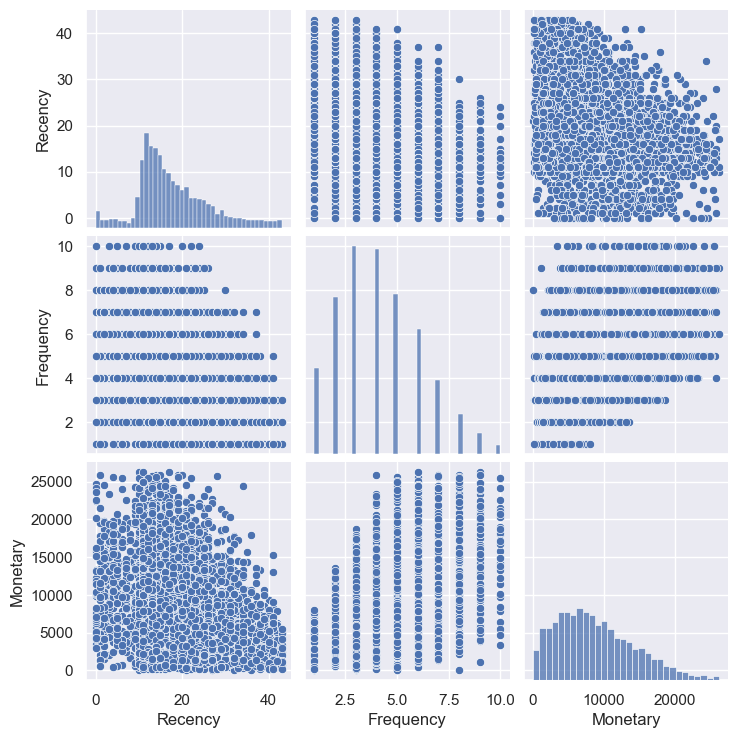

In [149]:
#mostrar comparacion
sns.pairplot(data_rfm)

Normalizing Data

In [150]:
''' def normalize_data(data, columns):
    scaler = preprocessing.MinMaxScaler()
    d = scaler.fit_transform(data[columns])
    scaled_df = pd.DataFrame(d, columns=columns)
    for c in columns :
        data['Norm'+c] = scaled_df[c] '''

" def normalize_data(data, columns):\n    scaler = preprocessing.MinMaxScaler()\n    d = scaler.fit_transform(data[columns])\n    scaled_df = pd.DataFrame(d, columns=columns)\n    for c in columns :\n        data['Norm'+c] = scaled_df[c] "

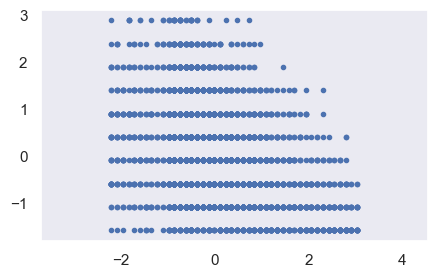

In [151]:
''' normalize_data(data_rfm,['Recency','Frequency','Monetary']) '''
from sklearn import preprocessing
#Se usa un PCA 
scaler = preprocessing.StandardScaler(with_mean=True,with_std=True).fit(data_rfm)
data_rfm = scaler.transform(data_rfm)
plt.plot(data_rfm[:,0],data_rfm[:,1],'.')
plt.axis('equal')
plt.grid()

In [152]:
print(data_rfm.shape)
print(data_rfm) 
#quitar las 3 primeras columnas

(5301, 3)
[[-0.36569999  0.41759563 -1.04429633]
 [ 1.09288097 -0.57530611 -0.57248578]
 [ 0.48513891  1.90694825  2.33859543]
 ...
 [ 1.94371987 -1.07175699 -0.6850333 ]
 [ 2.67301035 -1.07175699 -0.91598811]
 [ 0.36359049 -0.57530611 -1.0190388 ]]


In [153]:
covarianza = np.dot(data_rfm.T,data_rfm)
valores, vectores = np.linalg.eig(covarianza)
indice = np.argsort(-abs(valores))
valores = valores[indice]
vectores = vectores[:,indice] # vectores ordenados teniendo en cuenta la magnitud de los valores
print(valores)
print(vectores)

valores/np.sum(valores) # varianza explicada por componente

componentes = np.dot(data_rfm,vectores)

[9857.45615682 3987.90229362 2057.64154956]
[[ 0.48434636 -0.85576318 -0.18187354]
 [-0.63693566 -0.20240021 -0.74387305]
 [-0.59976793 -0.47613395  0.64309789]]


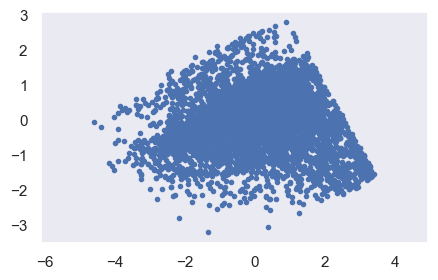

In [154]:
plt.plot(componentes[:,0],componentes[:,1],'.')
plt.axis('equal')
plt.grid()

In [155]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,whiten=False).fit(data_rfm)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)
transformados = pca.fit_transform(data_rfm)

[0.61984884 0.25076415]
[99.28472268 63.14984001]
[[-0.48434636  0.63693566  0.59976793]
 [ 0.85576318  0.20240021  0.47613395]]


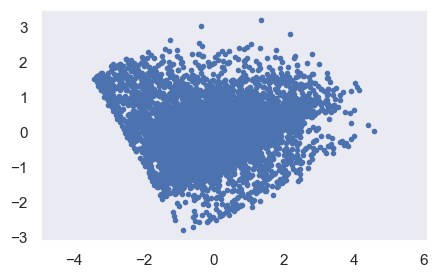

In [156]:
plt.plot(transformados[:,0],transformados[:,1],'.')
plt.axis('equal')
plt.grid()

In [157]:
''' data_rfm.loc[:, ['Recency',
                 'Monetary']].values '''
# extracting the above mentioned columns
datos_final =transformados
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(datos_final) # fitting the data to the object
distances,indices=nbrs.kneighbors(datos_final) # finding the nearest neighbours

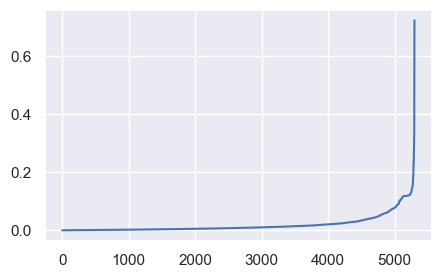

In [158]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot


In [159]:
# cluster the data into five clusters
dbscan = DBSCAN(eps = 0.245, min_samples = 2).fit(datos_final) # fitting the model
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_ # getting the labels

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

    
print(n_clusters_)
 

4


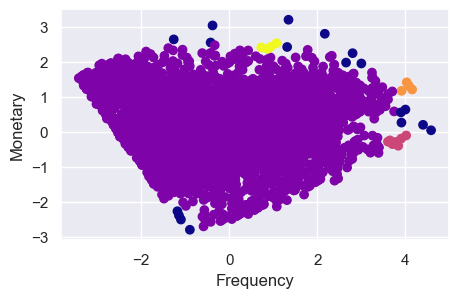

In [161]:
# Plot the clusters
plt.scatter(datos_final[:, 0], datos_final[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel("Frequency") # X-axis label
plt.ylabel("Monetary") # Y-axis label
plt.show() # showing the plot

In [160]:
''' # Black removed and is used for noise instead.
unique_labels = set(labels)
print(unique_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = datos_final[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = datos_final[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show() '''

' # Black removed and is used for noise instead.\nunique_labels = set(labels)\nprint(unique_labels)\ncolors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]\nfor k, col in zip(unique_labels, colors):\n    if k == -1:\n        # Black used for noise.\n        col = [0, 0, 0, 1]\n\n    class_member_mask = labels == k\n\n    xy = datos_final[class_member_mask & core_samples_mask]\n    plt.plot(\n        xy[:, 0],\n        xy[:, 1],\n        "o",\n        markerfacecolor=tuple(col),\n        markeredgecolor="k",\n        markersize=14,\n    )\n\n    xy = datos_final[class_member_mask & ~core_samples_mask]\n    plt.plot(\n        xy[:, 0],\n        xy[:, 1],\n        "o",\n        markerfacecolor=tuple(col),\n        markeredgecolor="k",\n        markersize=6,\n    )\n\nplt.title("Estimated number of clusters: %d" % n_clusters_)\nplt.show() '